In [61]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
import torch.nn.functional as F
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
import random

In [62]:
torch.manual_seed(42)
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
print(device)

cuda


In [63]:
# dataset prep
def dataset_prep(batch_size):
    transform=transforms.Compose([
            transforms.ToTensor(),
            transforms.Normalize((0.1307,), (0.3081,)),
            ])
    train_data = datasets.MNIST('mnist_data', train=True, download=True, transform=transform)
    test_data = datasets.MNIST('mnist_data', train=False, download=True, transform=transform)

    training_DataLoader = DataLoader(train_data, batch_size=batch_size, shuffle=True)
    testing_DataLoader= DataLoader(test_data, batch_size=batch_size, shuffle=True)
    return training_DataLoader, testing_DataLoader

In [64]:
class CNNModel(nn.Module):
    def __init__(self):
        super(CNNModel, self).__init__()
        self.conv1 = nn.Conv2d(1, 32, kernel_size=3, stride=1, padding=1)
        self.pool1 = nn.MaxPool2d(kernel_size=2, stride=2)

        self.dense1 = nn.Linear(32*14*14, 128)
        self.dense2 = nn.Linear(128, 10)

    def forward(self, x):
        x = self.conv1(x)
        x = F.relu(x)
        x = self.pool1(x)
        x = x.view(x.shape[0], -1)
        x = self.dense1(x)
        x = self.dense2(x)
        return F.log_softmax(x, dim=1)

In [65]:

def train(model, optimizer, train_loader):
    model.train()
    loss_func = torch.nn.CrossEntropyLoss()
    correct = 0
    total_samples = 0
    batch_loss=[]
    count = 0
    for i, batch in tqdm(enumerate(train_loader)):
        count += 1
        images, labels = batch[0].to(device), batch[1].to(device)
        # Forward pass
        output = model(images)
        loss = loss_func(output, labels)

        # Backward pass and optimization
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        # Update metrics
        _, predicted = torch.max(output.data, 1)
        correct += (predicted == labels).sum().item()
        total_samples += labels.size(0)

        batch_loss.append(loss.item())

    # Calculate average loss
    train_loss = sum(batch_loss) / count
    print(count)
    acc = 100. * correct / total_samples
    return train_loss, acc

In [66]:
def test(model, test_loader):
    model.eval()
    test_losses = []
    loss_func = torch.nn.CrossEntropyLoss()
    correct = 0
    total_samples = 0
    count = 0
    with torch.no_grad():
        for i, batch in enumerate(test_loader):
            count +=1
            images, labels = batch[0].to(device), batch[1].to(device)

            output = model(images)
            loss = loss_func(output, labels)
            test_losses.append(loss.item())

            _, pred = torch.max(output, 1)
            correct += (pred == labels).sum().item()
            total_samples += labels.size(0)


    # Calculate average loss
    test_loss = sum(test_losses) / count

    # Calculate accuracy
    accuracy = 100. * correct / total_samples


    return test_loss, accuracy

In [67]:
def sensitivity(model):
    total_norm = 0
    counter = 0
    
    for p in model.parameters():
        if p.grad is not None:
            grad_norm = torch.linalg.norm(p.grad.to(device)).cpu().item()
            total_norm += grad_norm
            counter += 1
    
    if counter == 0:
        return 0
    
    return total_norm / counter


In [68]:
epochs = 16
train_loss_dict = {}
train_acc_dict = {}
test_loss_dict = {}
test_acc_dict = {}
model_state = {}
sensivity_arr = []

for batch_size in [64, 128, 512, 2048, 4096]:
    train_loss_arr = []
    train_acc_arr = []
    test_loss_arr = []
    test_acc_arr = []
    training_DataLoader, testing_DataLoader = dataset_prep(batch_size)
    print(f"For Model with dataset batchsize - {batch_size}")
    model = CNNModel().to(device)
    optimizer1 = optim.SGD(model.parameters(), lr=1e-2)
    for epoch in range(epochs):
        train_loss, train_acc = train(model, optimizer1, training_DataLoader)
        test_loss, test_acc = test(model, testing_DataLoader)
        print(f'Epoch - {epoch} Train Loss - {train_loss:.6f} Test Loss - {test_loss:.6f} Train Accuracy - {train_acc:.6f} Test Accuracy - {test_acc:.6f}')
        train_loss_arr.append(train_loss)
        train_acc_arr.append(train_acc)
        test_loss_arr.append(test_loss)
        test_acc_arr.append(test_acc)
    key_str = f"model_{batch_size}"
    train_loss_dict[key_str] = train_loss_arr
    train_acc_dict[key_str] = train_acc_arr
    test_loss_dict[key_str] = test_loss_arr
    test_acc_dict[key_str] = test_acc_arr
    model_state[key_str] = model
    sensivity_arr.append(sensitivity(model))




For Model with dataset batchsize - 64


938it [00:13, 68.24it/s]


938
Epoch - 0 Train Loss - 0.412805 Test Loss - 0.257876 Train Accuracy - 88.976667 Test Accuracy - 92.680000


938it [00:13, 67.94it/s]


938
Epoch - 1 Train Loss - 0.228671 Test Loss - 0.180634 Train Accuracy - 93.346667 Test Accuracy - 94.800000


938it [00:14, 65.97it/s]


938
Epoch - 2 Train Loss - 0.168390 Test Loss - 0.148362 Train Accuracy - 95.260000 Test Accuracy - 95.790000


938it [00:13, 67.39it/s]


938
Epoch - 3 Train Loss - 0.128450 Test Loss - 0.120408 Train Accuracy - 96.415000 Test Accuracy - 96.550000


938it [00:13, 67.76it/s]


938
Epoch - 4 Train Loss - 0.104285 Test Loss - 0.098108 Train Accuracy - 97.078333 Test Accuracy - 96.990000


938it [00:14, 66.20it/s]


938
Epoch - 5 Train Loss - 0.089667 Test Loss - 0.087575 Train Accuracy - 97.478333 Test Accuracy - 97.350000


938it [00:13, 67.74it/s]


938
Epoch - 6 Train Loss - 0.079025 Test Loss - 0.079765 Train Accuracy - 97.736667 Test Accuracy - 97.550000


938it [00:13, 68.12it/s]


938
Epoch - 7 Train Loss - 0.070941 Test Loss - 0.070472 Train Accuracy - 98.010000 Test Accuracy - 97.850000


938it [00:13, 68.06it/s]


938
Epoch - 8 Train Loss - 0.065566 Test Loss - 0.066100 Train Accuracy - 98.120000 Test Accuracy - 97.900000


938it [00:13, 67.79it/s]


938
Epoch - 9 Train Loss - 0.060651 Test Loss - 0.062151 Train Accuracy - 98.238333 Test Accuracy - 98.020000


938it [00:13, 68.07it/s]


938
Epoch - 10 Train Loss - 0.056564 Test Loss - 0.060784 Train Accuracy - 98.353333 Test Accuracy - 98.120000


938it [00:13, 68.28it/s]


938
Epoch - 11 Train Loss - 0.053337 Test Loss - 0.062356 Train Accuracy - 98.438333 Test Accuracy - 97.920000


938it [00:13, 67.96it/s]


938
Epoch - 12 Train Loss - 0.050508 Test Loss - 0.059090 Train Accuracy - 98.551667 Test Accuracy - 98.170000


938it [00:14, 66.28it/s]


938
Epoch - 13 Train Loss - 0.047893 Test Loss - 0.057920 Train Accuracy - 98.616667 Test Accuracy - 98.160000


938it [00:15, 60.91it/s]


938
Epoch - 14 Train Loss - 0.045583 Test Loss - 0.058168 Train Accuracy - 98.673333 Test Accuracy - 98.180000


938it [00:16, 57.74it/s]


938
Epoch - 15 Train Loss - 0.043857 Test Loss - 0.056636 Train Accuracy - 98.746667 Test Accuracy - 98.230000
For Model with dataset batchsize - 128


469it [00:13, 35.99it/s]


469
Epoch - 0 Train Loss - 0.506578 Test Loss - 0.283572 Train Accuracy - 87.153333 Test Accuracy - 91.960000


469it [00:13, 35.92it/s]


469
Epoch - 1 Train Loss - 0.268816 Test Loss - 0.229927 Train Accuracy - 92.323333 Test Accuracy - 93.490000


469it [00:13, 35.93it/s]


469
Epoch - 2 Train Loss - 0.224041 Test Loss - 0.194064 Train Accuracy - 93.616667 Test Accuracy - 94.450000


469it [00:13, 35.88it/s]


469
Epoch - 3 Train Loss - 0.188900 Test Loss - 0.165975 Train Accuracy - 94.638333 Test Accuracy - 95.450000


469it [00:13, 33.73it/s]


469
Epoch - 4 Train Loss - 0.161576 Test Loss - 0.142397 Train Accuracy - 95.433333 Test Accuracy - 96.040000


469it [00:13, 35.66it/s]


469
Epoch - 5 Train Loss - 0.139012 Test Loss - 0.125207 Train Accuracy - 96.136667 Test Accuracy - 96.510000


469it [00:14, 31.56it/s]


469
Epoch - 6 Train Loss - 0.122287 Test Loss - 0.108305 Train Accuracy - 96.611667 Test Accuracy - 97.010000


469it [00:13, 35.91it/s]


469
Epoch - 7 Train Loss - 0.109247 Test Loss - 0.103055 Train Accuracy - 97.011667 Test Accuracy - 97.170000


469it [00:13, 35.99it/s]


469
Epoch - 8 Train Loss - 0.098306 Test Loss - 0.092871 Train Accuracy - 97.313333 Test Accuracy - 97.290000


469it [00:13, 35.85it/s]


469
Epoch - 9 Train Loss - 0.090759 Test Loss - 0.090223 Train Accuracy - 97.520000 Test Accuracy - 97.580000


469it [00:13, 35.91it/s]


469
Epoch - 10 Train Loss - 0.084187 Test Loss - 0.080185 Train Accuracy - 97.686667 Test Accuracy - 97.580000


469it [00:12, 36.09it/s]


469
Epoch - 11 Train Loss - 0.078743 Test Loss - 0.078518 Train Accuracy - 97.838333 Test Accuracy - 97.800000


469it [00:12, 36.11it/s]


469
Epoch - 12 Train Loss - 0.074278 Test Loss - 0.073466 Train Accuracy - 97.918333 Test Accuracy - 97.880000


469it [00:15, 30.73it/s]


469
Epoch - 13 Train Loss - 0.070396 Test Loss - 0.069866 Train Accuracy - 98.048333 Test Accuracy - 97.900000


469it [00:15, 30.40it/s]


469
Epoch - 14 Train Loss - 0.066921 Test Loss - 0.067252 Train Accuracy - 98.136667 Test Accuracy - 98.050000


469it [00:14, 32.62it/s]


469
Epoch - 15 Train Loss - 0.064101 Test Loss - 0.064534 Train Accuracy - 98.173333 Test Accuracy - 98.060000
For Model with dataset batchsize - 512


118it [00:12,  9.40it/s]


118
Epoch - 0 Train Loss - 0.942242 Test Loss - 0.464519 Train Accuracy - 80.091667 Test Accuracy - 88.520000


118it [00:14,  8.00it/s]


118
Epoch - 1 Train Loss - 0.413350 Test Loss - 0.349199 Train Accuracy - 88.890000 Test Accuracy - 90.550000


118it [00:12,  9.09it/s]


118
Epoch - 2 Train Loss - 0.346130 Test Loss - 0.318671 Train Accuracy - 90.288333 Test Accuracy - 91.000000


118it [00:14,  8.31it/s]


118
Epoch - 3 Train Loss - 0.314016 Test Loss - 0.290013 Train Accuracy - 91.016667 Test Accuracy - 92.090000


118it [00:14,  7.93it/s]


118
Epoch - 4 Train Loss - 0.293854 Test Loss - 0.273183 Train Accuracy - 91.611667 Test Accuracy - 92.410000


118it [00:12,  9.41it/s]


118
Epoch - 5 Train Loss - 0.278544 Test Loss - 0.258852 Train Accuracy - 92.038333 Test Accuracy - 92.750000


118it [00:12,  9.45it/s]


118
Epoch - 6 Train Loss - 0.265057 Test Loss - 0.248365 Train Accuracy - 92.421667 Test Accuracy - 92.960000


118it [00:12,  9.39it/s]


118
Epoch - 7 Train Loss - 0.253652 Test Loss - 0.238599 Train Accuracy - 92.701667 Test Accuracy - 93.390000


118it [00:12,  9.35it/s]


118
Epoch - 8 Train Loss - 0.243113 Test Loss - 0.227754 Train Accuracy - 93.093333 Test Accuracy - 93.430000


118it [00:13,  8.84it/s]


118
Epoch - 9 Train Loss - 0.234626 Test Loss - 0.221012 Train Accuracy - 93.335000 Test Accuracy - 93.930000


118it [00:14,  8.21it/s]


118
Epoch - 10 Train Loss - 0.225424 Test Loss - 0.218947 Train Accuracy - 93.641667 Test Accuracy - 93.650000


118it [00:12,  9.42it/s]


118
Epoch - 11 Train Loss - 0.216142 Test Loss - 0.204817 Train Accuracy - 93.901667 Test Accuracy - 94.250000


118it [00:12,  9.35it/s]


118
Epoch - 12 Train Loss - 0.207503 Test Loss - 0.196516 Train Accuracy - 94.168333 Test Accuracy - 94.580000


118it [00:12,  9.41it/s]


118
Epoch - 13 Train Loss - 0.199153 Test Loss - 0.189935 Train Accuracy - 94.383333 Test Accuracy - 94.570000


118it [00:14,  8.13it/s]


118
Epoch - 14 Train Loss - 0.191289 Test Loss - 0.186764 Train Accuracy - 94.645000 Test Accuracy - 94.750000


118it [00:12,  9.41it/s]


118
Epoch - 15 Train Loss - 0.183711 Test Loss - 0.178517 Train Accuracy - 94.860000 Test Accuracy - 95.070000
For Model with dataset batchsize - 2048


30it [00:12,  2.42it/s]


30
Epoch - 0 Train Loss - 1.653012 Test Loss - 1.121721 Train Accuracy - 67.760000 Test Accuracy - 81.430000


30it [00:12,  2.42it/s]


30
Epoch - 1 Train Loss - 0.896367 Test Loss - 0.695516 Train Accuracy - 82.880000 Test Accuracy - 85.560000


30it [00:12,  2.41it/s]


30
Epoch - 2 Train Loss - 0.628559 Test Loss - 0.537097 Train Accuracy - 85.775000 Test Accuracy - 87.100000


30it [00:13,  2.29it/s]


30
Epoch - 3 Train Loss - 0.515266 Test Loss - 0.460080 Train Accuracy - 87.156667 Test Accuracy - 88.510000


30it [00:14,  2.03it/s]


30
Epoch - 4 Train Loss - 0.455839 Test Loss - 0.413663 Train Accuracy - 88.086667 Test Accuracy - 89.390000


30it [00:14,  2.04it/s]


30
Epoch - 5 Train Loss - 0.417127 Test Loss - 0.384747 Train Accuracy - 88.736667 Test Accuracy - 89.810000


30it [00:14,  2.04it/s]


30
Epoch - 6 Train Loss - 0.391323 Test Loss - 0.363834 Train Accuracy - 89.233333 Test Accuracy - 90.230000


30it [00:14,  2.04it/s]


30
Epoch - 7 Train Loss - 0.373970 Test Loss - 0.345907 Train Accuracy - 89.590000 Test Accuracy - 90.400000


30it [00:14,  2.04it/s]


30
Epoch - 8 Train Loss - 0.358939 Test Loss - 0.334340 Train Accuracy - 89.970000 Test Accuracy - 90.850000


30it [00:14,  2.03it/s]


30
Epoch - 9 Train Loss - 0.346192 Test Loss - 0.323041 Train Accuracy - 90.243333 Test Accuracy - 91.110000


30it [00:13,  2.29it/s]


30
Epoch - 10 Train Loss - 0.335718 Test Loss - 0.314606 Train Accuracy - 90.433333 Test Accuracy - 91.180000


30it [00:12,  2.43it/s]


30
Epoch - 11 Train Loss - 0.327603 Test Loss - 0.307695 Train Accuracy - 90.670000 Test Accuracy - 91.430000


30it [00:12,  2.41it/s]


30
Epoch - 12 Train Loss - 0.320357 Test Loss - 0.300433 Train Accuracy - 90.836667 Test Accuracy - 91.530000


30it [00:12,  2.42it/s]


30
Epoch - 13 Train Loss - 0.313640 Test Loss - 0.293305 Train Accuracy - 91.046667 Test Accuracy - 91.870000


30it [00:12,  2.41it/s]


30
Epoch - 14 Train Loss - 0.306623 Test Loss - 0.289068 Train Accuracy - 91.195000 Test Accuracy - 91.750000


30it [00:12,  2.42it/s]


30
Epoch - 15 Train Loss - 0.300604 Test Loss - 0.284153 Train Accuracy - 91.383333 Test Accuracy - 91.970000
For Model with dataset batchsize - 4096


15it [00:12,  1.21it/s]


15
Epoch - 0 Train Loss - 1.894867 Test Loss - 1.507291 Train Accuracy - 57.150000 Test Accuracy - 75.010000


15it [00:12,  1.21it/s]


15
Epoch - 1 Train Loss - 1.296705 Test Loss - 1.065856 Train Accuracy - 77.076667 Test Accuracy - 81.510000


15it [00:12,  1.22it/s]


15
Epoch - 2 Train Loss - 0.957450 Test Loss - 0.821054 Train Accuracy - 81.906667 Test Accuracy - 84.670000


15it [00:12,  1.22it/s]


15
Epoch - 3 Train Loss - 0.764464 Test Loss - 0.669168 Train Accuracy - 84.373333 Test Accuracy - 86.470000


15it [00:12,  1.20it/s]


15
Epoch - 4 Train Loss - 0.647140 Test Loss - 0.586331 Train Accuracy - 85.728333 Test Accuracy - 87.610000


15it [00:12,  1.21it/s]


15
Epoch - 5 Train Loss - 0.571616 Test Loss - 0.512334 Train Accuracy - 86.745000 Test Accuracy - 88.240000


15it [00:12,  1.22it/s]


15
Epoch - 6 Train Loss - 0.518973 Test Loss - 0.472384 Train Accuracy - 87.465000 Test Accuracy - 88.820000


15it [00:12,  1.22it/s]


15
Epoch - 7 Train Loss - 0.481483 Test Loss - 0.446088 Train Accuracy - 87.975000 Test Accuracy - 89.340000


15it [00:12,  1.21it/s]


15
Epoch - 8 Train Loss - 0.453059 Test Loss - 0.419123 Train Accuracy - 88.458333 Test Accuracy - 89.620000


15it [00:12,  1.21it/s]


15
Epoch - 9 Train Loss - 0.429989 Test Loss - 0.394999 Train Accuracy - 88.780000 Test Accuracy - 89.920000


15it [00:12,  1.21it/s]


15
Epoch - 10 Train Loss - 0.411556 Test Loss - 0.380637 Train Accuracy - 89.050000 Test Accuracy - 90.120000


15it [00:12,  1.21it/s]


15
Epoch - 11 Train Loss - 0.397027 Test Loss - 0.366516 Train Accuracy - 89.305000 Test Accuracy - 90.390000


15it [00:12,  1.21it/s]


15
Epoch - 12 Train Loss - 0.383941 Test Loss - 0.359879 Train Accuracy - 89.496667 Test Accuracy - 90.530000


15it [00:12,  1.21it/s]


15
Epoch - 13 Train Loss - 0.373584 Test Loss - 0.346915 Train Accuracy - 89.655000 Test Accuracy - 90.800000


15it [00:12,  1.21it/s]


15
Epoch - 14 Train Loss - 0.363738 Test Loss - 0.342900 Train Accuracy - 89.848333 Test Accuracy - 90.970000


15it [00:12,  1.21it/s]


15
Epoch - 15 Train Loss - 0.355515 Test Loss - 0.329475 Train Accuracy - 90.060000 Test Accuracy - 91.080000


In [76]:
all_train_loss_arr = []
all_test_loss_arr = []
for item in train_loss_dict.values():
    all_train_loss_arr.append(np.mean(item))
for item in test_loss_dict.values():
    all_test_loss_arr.append(np.mean(item))


In [77]:
all_train_loss_arr

[0.10663714386870249,
 0.14675931173373263,
 0.3004877752845444,
 0.4963211667413513,
 0.6438191536813975]

In [78]:
sensivity_arr

[0.12916104961186647,
 0.3922826924050848,
 0.36900745797902346,
 0.14714564165721336,
 0.11652321578003466]

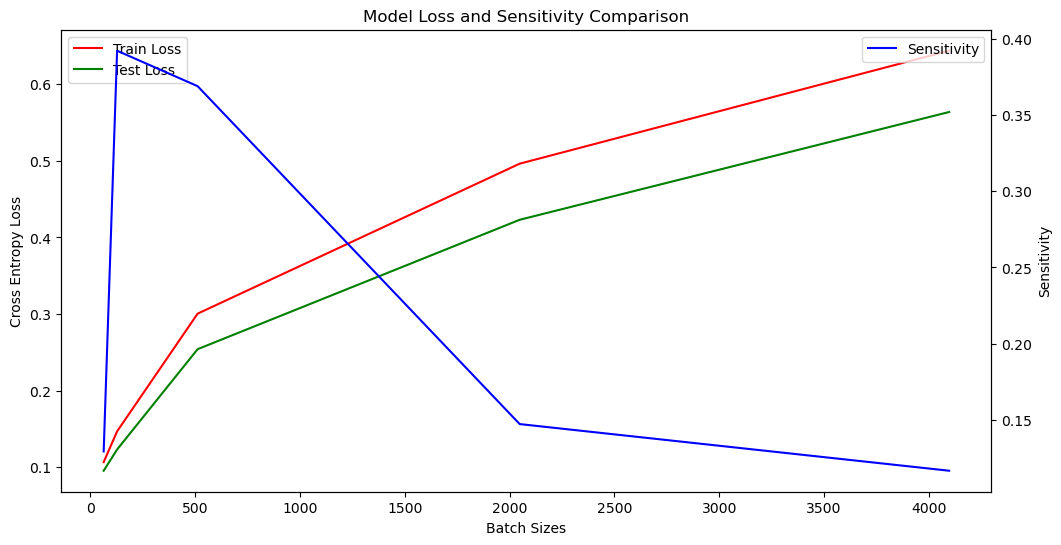

In [80]:
plt.figure(figsize=(12, 6))

# Plot train and test loss
plt.plot([64, 128, 512, 2048, 4096], all_train_loss_arr, color="red", label='Train Loss')
plt.plot([64, 128, 512, 2048, 4096], all_test_loss_arr, color="green", label='Test Loss')
plt.xlabel('Batch Sizes')
plt.ylabel('Cross Entropy Loss')
plt.legend(loc='upper left')

# Create a second y-axis for sensitivity
ax2 = plt.twinx()
plt.plot([64, 128, 512, 2048, 4096], sensivity_arr, color="blue", label='Sensitivity')
plt.ylabel('Sensitivity')
plt.legend(loc='upper right')

plt.title('Model Loss and Sensitivity Comparison')
plt.xlabel('Batch Sizes')

plt.show()


In [81]:
all_train_acc_arr = []
all_test_acc_arr = []
for item in train_acc_dict.values():
    all_train_acc_arr.append(np.mean(item))
for item in test_acc_dict.values():
    all_test_acc_arr.append(np.mean(item))

In [82]:
all_train_acc_arr, all_test_acc_arr

([97.0025, 95.9725, 91.94302083333334, 87.81229166666667, 85.19208333333333],
 [97.14125, 96.51375, 92.99375, 89.63250000000001, 87.81875])

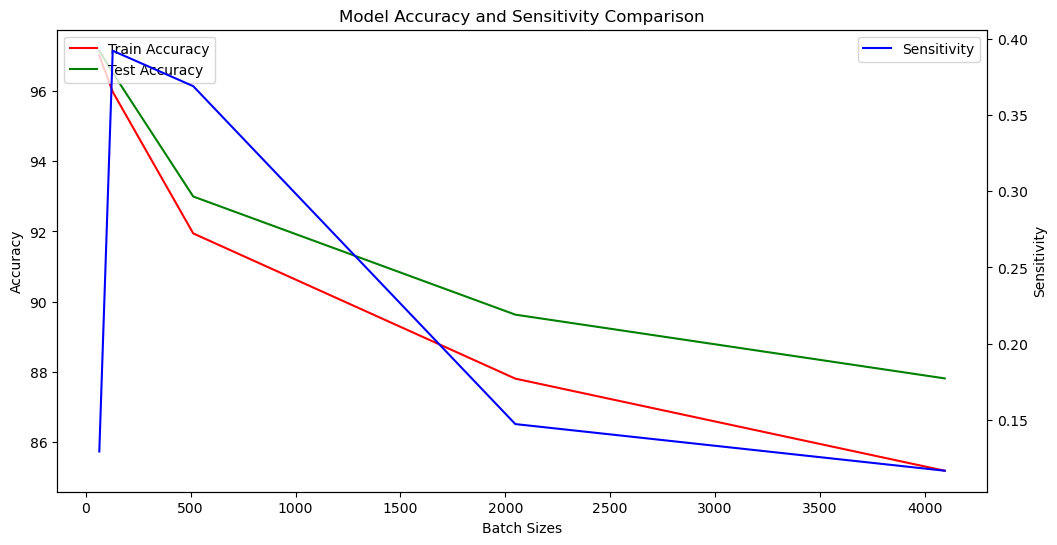

In [83]:
plt.figure(figsize=(12, 6))

# Plot train and test accuracy
plt.plot([64, 128, 512, 2048, 4096], all_train_acc_arr, color="red", label='Train Accuracy')
plt.plot([64, 128, 512, 2048, 4096], all_test_acc_arr, color="green", label='Test Accuracy')
plt.xlabel('Batch Sizes')
plt.ylabel('Accuracy')
plt.legend(loc='upper left')

# Create a second y-axis for sensitivity
ax2 = plt.twinx()
plt.plot([64, 128, 512, 2048, 4096], sensivity_arr, color="blue", label='Sensitivity')
plt.ylabel('Sensitivity')
plt.legend(loc='upper right')

plt.title('Model Accuracy and Sensitivity Comparison')

plt.show()
